In [1]:
# load functions for data analysis
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy, sys
import seaborn as sns
import numpy as np
from scipy import stats
pandas.options.mode.chained_assignment = None
sns.set_style("dark", {'axes.grid' : False})

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# scr data anslysis functions
sys.path.append(os.getcwd() + '/scr/')
from scr_analysis_functions_fyp import experimental

In [4]:
# behavioral analysis functions
sys.path.append(os.getcwd() + '/self_report/')
import behavioral_analysis_functions as behavioral_functions

In [5]:
# paths to behavioral data
behavioral_data_path = os.getcwd() + '/self_report/data_study_one/'

In [6]:
# paths to scr data
scr_data_path =  os.getcwd() + '/scr/data_study_one'

In [7]:
results_folder = 'results/figures'

In [8]:
day_one = experimental(scr_data_path)
day_one.day = 1
day_one.preprocessData()

In [9]:
day_two = experimental(scr_data_path)
day_two.day = 2
day_two.preprocessData()

In [10]:
def show_subject_scr_across_experiment(): 
    
    figure(figsize=[20,4])
    i_subject = 5
    sns.set_style("white", {'axes.grid' : False})
    offset = 1
    _alpha_ = .1
    _subject_data_ = day_one.transData[i_subject][0]
    _cs_plus_ = day_one.transData[i_subject][1][:,0]
    _cs_minus_ = day_one.transData[i_subject][1][:,1]
    _us_ = day_one.transData[i_subject][1][:,2]

    plot(_subject_data_, label='SCR', linewidth=2, color='xkcd:black')
    plot(3* _cs_plus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:red', label='CS+')
    plot(3* _cs_minus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:blue', label='CS-')
    plot(3* _us_-5, linewidth=2, alpha=.5, color='crimson', label='US')

    ylim([np.min(day_one.transData[i_subject][0])-offset,np.max(day_one.transData[i_subject][0])+offset])
    xlim([0, len(day_one.transData[i_subject][1][:,1])]); xticks([]) ; yticks([])
    ylabel('z-scored\nskin conductance response', fontsize=15, fontweight='bold')
    title('Skin conductance response of a single subject across day one', y=1.1, fontsize=30, fontweight='bold')
    xlabel('\ntime', fontsize=15, fontweight='bold')
    legend(bbox_to_anchor=(1, .9), fontsize=25); 
    savefig('%s/study_one_scr_timecourse_single_subject.png'%results_folder,  bbox_inches='tight',)
    

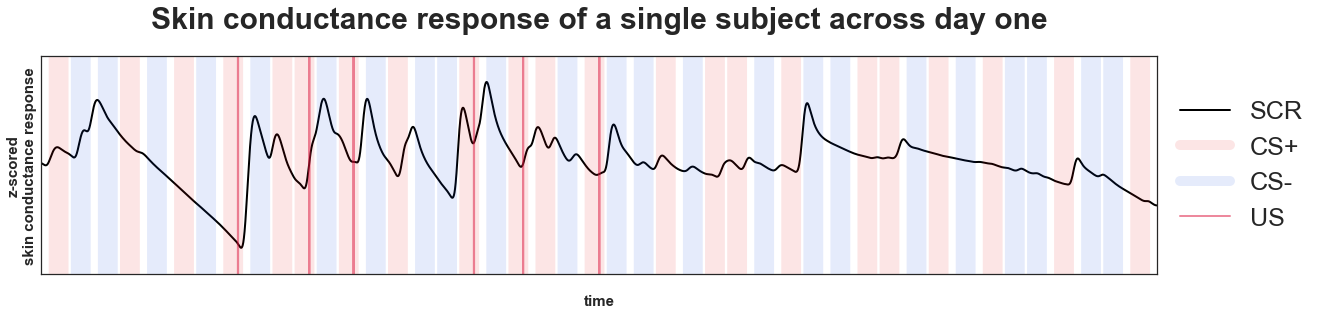

In [11]:
show_subject_scr_across_experiment()

In [12]:
def show_group_average_scr_across_experiment(): 
    
    min_len = np.array([np.shape(day_one.transData[i][0])[0] for i in range(len(day_one.transData))]).min()
    average_scr = np.array([np.array(day_one.transData[i_subject][0][0:min_len]) for i_subject in range(len(day_one.transData))]).mean(0)
    
    
    figure(figsize=[20,4])
    i_subject = 5
    offset = 1
    _alpha_ = .1
    _cs_plus_ = day_one.transData[i_subject][1][:,0]
    _cs_minus_ = day_one.transData[i_subject][1][:,1]
    _us_ = day_one.transData[i_subject][1][:,2]

    plot(average_scr, label='SCR', linewidth=2, color='xkcd:black')
    plot(3* _cs_plus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:red', label='CS+')
    plot(3* _cs_minus_ -5, linewidth=10, alpha=_alpha_, color='xkcd:blue', label='CS-')
    plot(3* _us_-5, linewidth=2, alpha=1, color='crimson', label='US')

    ylim([np.min(average_scr)-offset,np.max(average_scr)+offset])
    xlim([0, len(day_one.transData[i_subject][1][:,1])]); xticks([]) ; yticks([])
    ylabel('z-scored\nskin conductance response', fontsize=15, fontweight='bold')
    xlabel('\ntime', fontsize=15, fontweight='bold')
    title('Skin conductance response averaged across all subjects on day one', y=1.1, fontsize=30, fontweight='bold')
    xlabel('\ntime', fontsize=15, fontweight='bold')
    legend(bbox_to_anchor=(1, .9), fontsize=26); 
    savefig('%s/study_one_scr_timecourse_averaged_subjects.png'%results_folder, bbox_inches='tight')

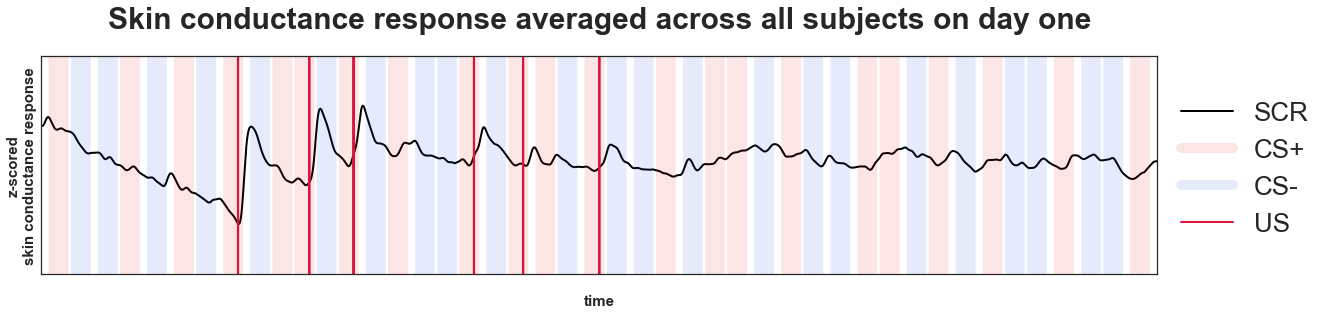

In [13]:
show_group_average_scr_across_experiment()

In [14]:
def counterbalance_info(_data_): 
    
    cb, bc, order = [], [], np.zeros(_data_.nSubjects)

    for iSubject in range(0,len(_data_.subjectNames)): 
        
        if str.find(_data_.subjectNames[iSubject], '_cb_') != -1: cb.append(iSubject)
        else: bc.append(iSubject)
            
    order[cb] = 1
    
    _dict_ = {'counter_balanced_inds':np.array(cb), 
              'not_counter_balanced_inds': np.array(bc), 
              'order': order} 

    return _dict_

In [15]:
def log_transform(_a_): 
    """convenience function"""
    return np.log(1 + _a_)

In [16]:
def extract_conditioning_data(scr_data_, type_ , location_, dict_=''):
    '''
    scr_data_ is either day_one or day_two
    type_ is either 'raw' or 'trans'
    location_ is either 'onset' (predictive) or 'offset' (contagion)
    '''
    
    if not dict_: dict_ = {}
    
    dict_['%s_%s'%(type_, location_)] = {} 
    
    if location_ == 'onset':
        # look at all onsets after the initial shock, during conditioning
        start_ind, end_ind = 4, 13 
        trial_ = list(range(start_ind, end_ind))
        positive_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
        negative_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
    else: 
        # only look at offsets when the model was shocked
        trial_ = np.array([3, 5, 6, 8, 9, 11])
        positive_ = np.zeros([scr_data_.nSubjects,len(trial_)])
        negative_ = np.zeros([scr_data_.nSubjects,len(trial_)])
    
    for i_stim in range(0,len(trial_)):
        positive_[:,i_stim], negative_[:,i_stim] = scr_data_.amplitudeDifference(type_, trial_[i_stim], location_);

    significance_ = np.zeros(scr_data_.nSubjects)
    for iSubject in range(0,scr_data_.nSubjects): 
        significance_[iSubject] = scipy.stats.ttest_ind(positive_[iSubject,:], negative_[iSubject,:])[1];

    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(positive_)
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(negative_)
    dict_['%s_%s'%(type_, location_)]['significe_difference'] = significance_
    dict_['%s_%s'%(type_, location_)]['learning'] = mean(log_transform(positive_) - log_transform(negative_),1)
    
    return dict_

In [17]:
def extract_renewal_data(day_two, type_, location_, dict_=''): 
        
    if not dict_: dict_ = {} 
    dict_['%s_%s'%(type_, location_)] = {} 
        
    plus, minus = day_two.amplitudeDifference(type_, 0, location_);
    
    dict_['%s_%s'%(type_, location_)]['contrast'] = log_transform(plus) - log_transform(minus) 
    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(plus) 
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(minus)
    
    return dict_


In [18]:

def test_single_relationship(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[0,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)

def control_for_order(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ C(order) + %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[1,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)
    
def full_model(_df_): 
    formula = 'renewal ~ C(order) +  prediction + contagion'
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[1,3]
    print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
def show_first_contagion_response(_cndioning_): 

    _pos_ = _cndioning_['trans_offset']['positive_stim'][:,0]
    _neg_ = _cndioning_['trans_offset']['negative_stim'][:,0]
    p_val = stats.ttest_ind(_pos_,_neg_)[1]
    
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    _plus_color, _minus_color = 'xkcd:red', 'xkcd:blue'
    
    _alpha_, _scale = .5, 30
    n_points = len(_pos_)
    _jitter1 = np.random.randn(n_points)/_scale
    _jitter2 = np.random.randn(n_points)/_scale

    scatter(np.ones(n_points) + _jitter1, _neg_, s=500, color='white')
    scatter(np.zeros(n_points) + _jitter2, _pos_, s=500,  color='white')  
    scatter(np.ones(n_points) + _jitter1, _neg_, label='CS-', s=150, color=_minus_color, alpha=_alpha_)
    scatter(np.zeros(n_points) + _jitter2, _pos_, label='CS+', s=150, color=_plus_color, alpha=_alpha_)
    ylabel('Magnitude of SCR\n', rotation=90, fontsize=20, fontweight='bold')

    yticks([0,.5,],[ 0.,.5], fontsize=15); xlim(-.5, 1.5) ; ylim(-.5, 3)
    xticks([0, 1],['\nCS+','\nCS-'], fontsize=18, fontweight='bold')
    title('\nSubjects show differential response to US (p < %.1e)\n'%p_val, 
          fontsize=18,fontweight='bold'); 
    savefig('%s/study_one_first_us.png'%results_folder, bbox_inches='tight')
    
    return _pos_ - _neg_ 
    

In [19]:
def show_order_effects(): 
    
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(order))/100
    scatter(order + jitter,log_renewal, alpha=.8, s=90)
    scatter(order + jitter,log_renewal, color='darkcyan', alpha=.1, s=300)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([-.5,0,.5,],[-.5,0,.5])
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    xlim(-.2, 1.2)
    ylim(-2.5, 3)
    title('Main Effect of order on SCR to CS on day two (p < %.04f)\n'%p_val_order_effects, fontsize=15); 


In [20]:
# extract measure of predictive learning across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'onset')
# extract measure of emotional contagion across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'offset', conditioning)
# extract measure for determining non-responders
conditioning = extract_conditioning_data(day_one, 'raw', 'onset', conditioning)

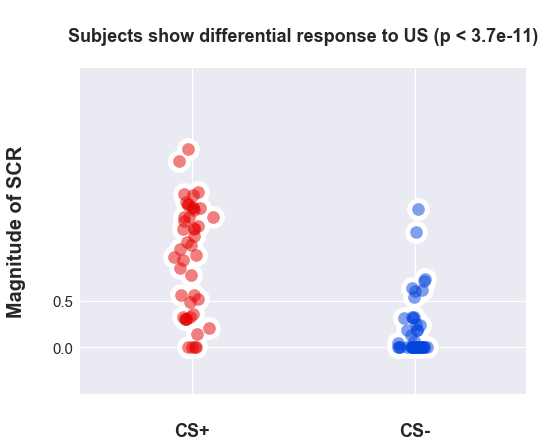

In [21]:
conditioning['trans_onset']['initial_difference_contagion'] = show_first_contagion_response(conditioning)

In [22]:
# renewal measure -- main dependent variable of the experiment 
renewal = extract_renewal_data(day_two, 'trans', 'onset')
renewal = extract_renewal_data(day_two, 'raw',   'onset', renewal)

In [23]:
# extract information about the order of presentation of day two
counter_balance_info = counterbalance_info(day_two)

In [24]:
# set criteria for responders -- at least one scr responce > .1
responders = np.array(conditioning['raw_onset']['positive_stim'] > .1).mean(1) > 0

In [25]:
# reformat into a data frame
SCR = pandas.DataFrame({'renewal':renewal['trans_onset']['contrast'],
                        'order':counter_balance_info['order'],
                        'contagion':conditioning['trans_offset']['learning'],
                        'prediction': conditioning['trans_onset']['learning'], 
                        'contagion_initial_diff': conditioning['trans_onset']['initial_difference_contagion']})

In [26]:
# remove non-responders 
responders_data = SCR[responders]

In [27]:
# determine significance and display
renewal['significance'] = {} 
renewal['significance']['order'] = test_single_relationship(responders_data, 'order')


		renewal ~ order 

             sum_sq    df          F    PR(>F)
order     10.131943   1.0  20.795138  0.000092
Residual  13.642343  28.0        NaN       NaN 



In [28]:
def show_order_effects(): 
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(counter_balance_info['order']))/100
    _alpha_ = .6
    _scale = 30
    _jitter1 =  np.random.randn(np.sum(counter_balance_info['order']==0))/_scale
    _jitter2 = np.random.randn(np.sum(counter_balance_info['order']==1))/_scale
    _jitter3 = np.random.randn(np.sum(counter_balance_info['order']==1))/_scale
    _jitter4 = np.random.randn(np.sum(counter_balance_info['order']==0))/_scale

    _plus_color = 'xkcd:red'
    _minus_color = 'xkcd:blue'
    scatter(np.ones(np.sum(counter_balance_info['order']==0)) + _jitter1, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==0], s=500, color='white')
    scatter(np.zeros(np.sum(counter_balance_info['order']==1)) + _jitter2, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==1], s=500,  color='white')
    scatter(np.ones(np.sum(counter_balance_info['order']==1)) + _jitter3, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==1], s=500, color='white')
    scatter(np.zeros(np.sum(counter_balance_info['order']==0)) + _jitter4, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==0],s=500, color='white')
    
    scatter(np.ones(np.sum(counter_balance_info['order']==0)) + _jitter1, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==0], 
            label='CS-', s=150, color=_minus_color, alpha=_alpha_)
    scatter(np.zeros(np.sum(counter_balance_info['order']==1)) + _jitter2, 
        renewal['trans_onset']['negative_stim'][counter_balance_info['order']==1], 
            s=150, color=_minus_color, alpha=_alpha_)
    scatter(np.ones(np.sum(counter_balance_info['order']==1)) + _jitter3, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==1], 
            label='CS+', s=150, color=_plus_color, alpha=_alpha_)
    scatter(np.zeros(np.sum(counter_balance_info['order']==0)) + _jitter4, 
        renewal['trans_onset']['positive_stim'][counter_balance_info['order']==0],
            s=150, color=_plus_color, alpha=_alpha_)
    
    legend(bbox_to_anchor=(1, 1), fontsize=20)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([0,.5,],[ 0,.5]); xlim(-.5, 1.5) ; ylim(-.5, 3)
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    title('\nMain Effect of order on skin conductance \nresponse to CS on day two (p < %.04f)\n'
          %renewal['significance']['order'], fontsize=20,fontweight='bold'); 
    savefig('%sstudy_one_order_effects.png'%results_folder, bbox_inches='tight')
    

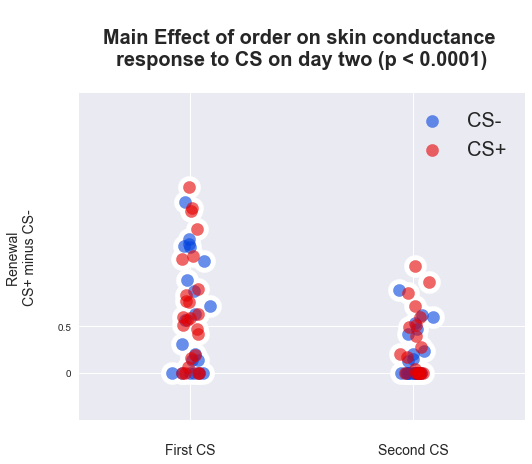

In [29]:
show_order_effects()

In [30]:
renewal['significance']['prediction']  = test_single_relationship(responders_data, 'prediction')


		renewal ~ prediction 

               sum_sq    df          F    PR(>F)
prediction   6.568438   1.0  10.689172  0.002855
Residual    17.205848  28.0        NaN       NaN 



In [31]:
renewal['significance']['contagion']   = test_single_relationship(responders_data, 'contagion')


		renewal ~ contagion 

              sum_sq    df         F    PR(>F)
contagion   0.047000   1.0  0.055464  0.815529
Residual   23.727286  28.0       NaN       NaN 



In [32]:
renewal['significance']['prediction_controlled'] = control_for_order(responders_data, 'prediction')


		renewal ~ C(order) + prediction 

               sum_sq    df          F    PR(>F)
C(order)     6.383237   1.0  15.924754  0.000454
prediction   2.819733   1.0   7.034604  0.013222
Residual    10.822610  27.0        NaN       NaN 



In [33]:
renewal['significance']['contagion_controlled']  = control_for_order(responders_data, 'contagion')


		renewal ~ C(order) + contagion 

              sum_sq    df          F    PR(>F)
C(order)   10.333372   1.0  20.830433  0.000098
contagion   0.248429   1.0   0.500793  0.485216
Residual   13.393914  27.0        NaN       NaN 



In [34]:
full_model(responders_data)


		renewal ~ C(order) +  prediction + contagion 

               sum_sq    df          F    PR(>F)
C(order)     5.783204   1.0  13.967033  0.000924
prediction   2.628327   1.0   6.347679  0.018235
contagion    0.057023   1.0   0.137716  0.713569
Residual    10.765587  26.0        NaN       NaN 



In [35]:
def show_relationships(): 
    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})
    subplot(121)
    type_color = 'xkcd:indigo'
    scatter(SCR['contagion'],SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    scatter(SCR['contagion'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['contagion'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    legend( bbox_to_anchor=(.20, 1, 1, -.1), fontsize=13)
    xlabel('Emotional contagion on day one\n CS+ minus CS- at shock offset',fontsize=13, fontweight='bold')
    ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13, fontweight='bold')
    #xlim(-.4,1)
    title('Relationship between emotional contagion and renewal (p < %.1f)\n' 
          %(renewal['significance']['contagion']), fontsize=18, fontweight='bold'); 

    subplot(122)
    type_color = 'xkcd:indigo'
    scatter(SCR['prediction'], SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    #scatter(log_learning[responders == True], log_renewal[responders == True],color='yellow',alpha=1,s=300, label='responders')

    scatter(SCR['prediction'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['prediction'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    xlabel('Predictive learning on day one\n CS+ minus CS- at stimulus onset',fontsize=13, fontweight='bold')
    yticks([-.1,0,.1],['','',''])
    title('\n Relationship between predictive learning and renewal (p < %.3f)\n' 
          %(renewal['significance']['prediction']), fontsize=18, fontweight='bold'); 
    t = suptitle('Relationship between learning measures on day one with renewal', y =1.15, fontsize=20, fontweight='bold')
    
    savefig('%sday_one_scr_comparision.png'%results_folder, bbox_extra_artists=[t])

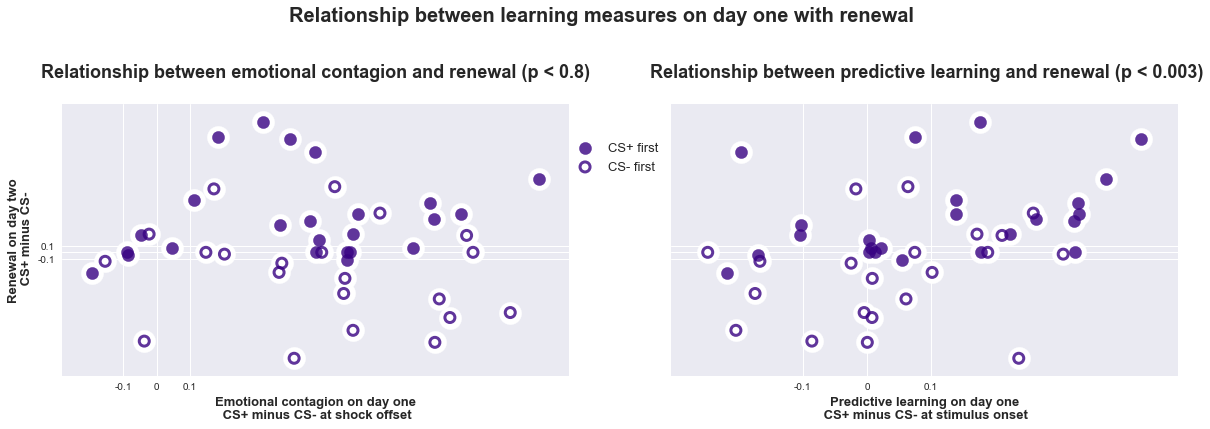

In [36]:
show_relationships()

In [37]:
def partition_analysis(_cond, _rnwl, _title, _figure_name): 
    
    cutoffs = {'1) significance':.05,
               '2) upper_quartile':np.percentile(conditioning['trans_onset']['significe_difference'], 25), 
               '3) upper third': np.percentile(conditioning['trans_onset']['significe_difference'], 33)}
    
    cutoff_keys = cutoffs.keys(); cutoff_keys.sort() 

    cond_sig_on = np.zeros(day_one.nSubjects)
    for i_subject in range(0,day_one.nSubjects): 
        cond_sig_on[i_subject] = scipy.stats.ttest_ind(_cond['positive_stim'][i_subject,:], 
                                                       _cond['negative_stim'][i_subject,:])[1];

    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})

    for i_cutoff in range(len(cutoffs)): 

        subplot(1,3,i_cutoff + 1)
        _i_cut = cutoff_keys[i_cutoff]
        _cutoff = cutoffs[_i_cut]

        con_subs_= find(cond_sig_on < _cutoff)

        tmp_len_p = len(_rnwl['positive_stim'][con_subs_])
        tmp_len_n = len(_rnwl['negative_stim'][con_subs_])
        jitter_p = np.random.randn(tmp_len_p)/200
        jitter_n = np.random.randn(tmp_len_n)/200

        _results_ = scipy.stats.ttest_ind(_rnwl['positive_stim'][con_subs_], _rnwl['negative_stim'][con_subs_])

        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=300, alpha=1,color='white') 
        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=100, alpha=.5,color='xkcd:red') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=300, alpha=1, color='white') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=100, alpha=.5, color='midnightblue') 
        xlim([-.1,.4])
        xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
        yticks([0,.5], [0.,.5], fontsize=10); 
        ylabel('Skin Conductance Response\nat first presentation of stimuli on day two')
        title('\n Subjects below %s (p < %.2f) : p < %.2f\n'%(_i_cut, _cutoff, _results_.pvalue), fontsize=15); 
    
    if _title == 'contagion': _tmp_ = "don't"
    else: _tmp_ = ''
    
    t = suptitle('Subjects who demonstrate %s learning on day one (across multiple threshholds) %s demonstrate renewal'%
                 (_title, _tmp_), fontsize=20, fontweight='bold',y=1.1);
    
    savefig('%ssegmentation_analyis_%s_%s.png'%(results_folder, _title, _figure_name), bbox_extra_artists=[t])
    
    return cond_sig_on

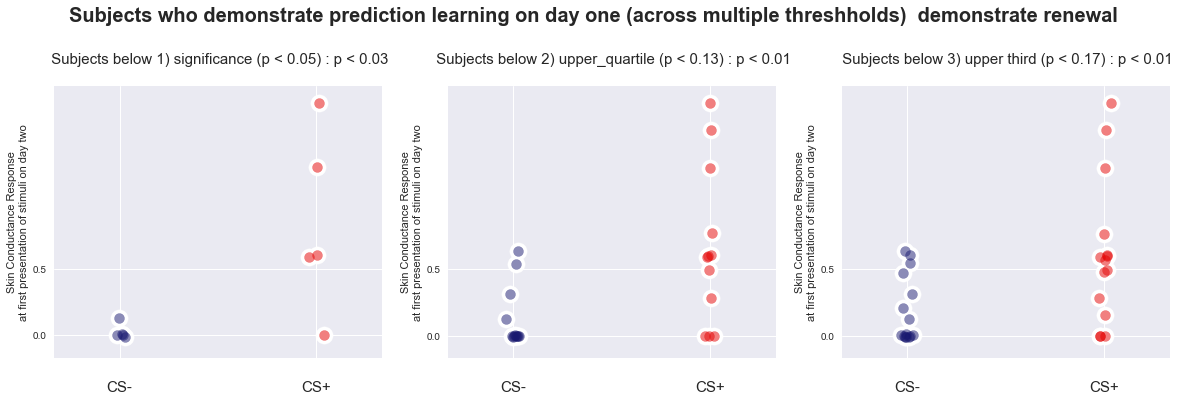

In [38]:
onset_significance = partition_analysis(conditioning['trans_onset'], renewal['trans_onset'], 'prediction', 'study_one')

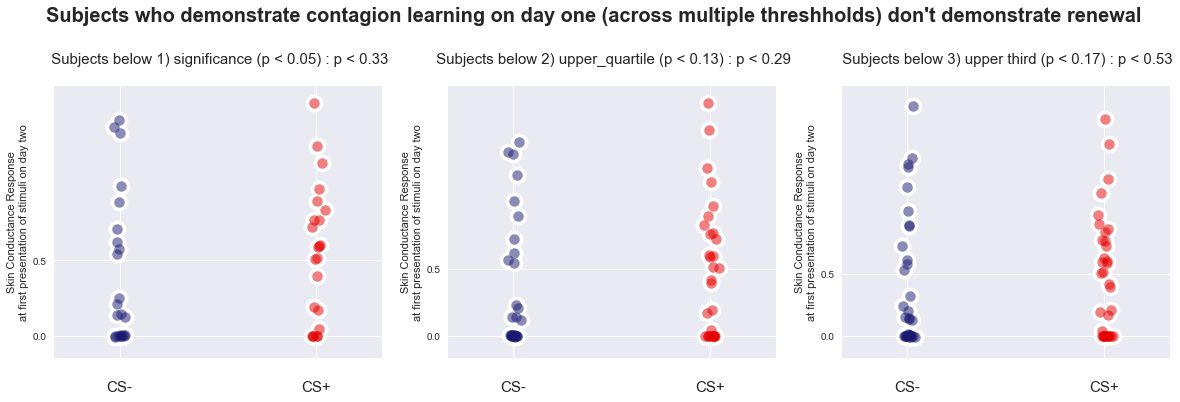

In [39]:
offset_significance = partition_analysis(conditioning['trans_offset'], renewal['trans_onset'], 'contagion', 'study_one')

In [40]:
cond_sig_on = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_on[i_subject] = scipy.stats.ttest_ind(conditioning['trans_onset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_onset']['negative_stim'][i_subject,:])[1];
    
cond_sig_off = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_off[i_subject] = scipy.stats.ttest_ind(conditioning['trans_offset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_offset']['negative_stim'][i_subject,:])[1];

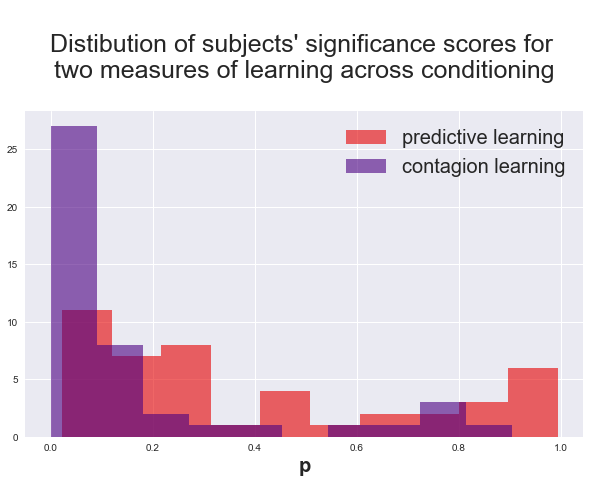

In [41]:
figure(figsize=[10,6])
hist(cond_sig_on, alpha=.6, label='predictive learning', color='xkcd:red')
hist(cond_sig_off, alpha=.6, label='contagion learning', color='indigo'); 
legend(fontsize=20)
title("\nDistibution of subjects' significance scores for \ntwo measures of learning across conditioning\n", fontsize=25); 
xlabel('p', fontweight='bold', fontsize=20); 

In [42]:
self_report, subject_names = behavioral_functions.generate_data_frame(behavioral_data_path)

In [43]:
SCR_all = pandas.DataFrame({'renewal':renewal['trans_onset']['contrast'], 
                            'prediction':conditioning['trans_onset']['learning'], 
                            'contagion':conditioning['trans_offset']['learning'], 
                            'order':abs(1-counter_balance_info['order']), 
                            'contagion_initial': conditioning['trans_onset']['initial_difference_contagion']}) 

SCR_all['subject_names'] = [day_two.subjectNames[ii][0:4] for ii in range(day_two.nSubjects)]

In [44]:
for ii in range(len(SCR_all)): 
    name = SCR_all.subject_names.values[ii]
    found = 0
    for jj in range(len(self_report)): 
        if name in self_report.index.values[jj]: 
            found = 1
    if found == 0 : 
        missing_subject = ii

In [45]:
SCR_all = SCR_all.drop(missing_subject)
onset_significance_corrected = np.delete(onset_significance, missing_subject)
offset_significance_corrected = np.delete(offset_significance, missing_subject)

In [46]:
tmp_data = {}
indices = [] 
for ii in range(len(SCR_all.keys())): 
    tmp_data[SCR_all.keys()[ii]] = SCR_all[SCR_all.keys()[ii]].values

for ii in range(len(self_report.keys())): 
    tmp_data[self_report.keys()[ii]] = self_report[self_report.keys()[ii]].values

In [47]:
physio_selfreport = pandas.DataFrame.from_dict(tmp_data)

In [48]:
physio_selfreport.correctColor = physio_selfreport.correctColor.values * 1

In [49]:
cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(':', '') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

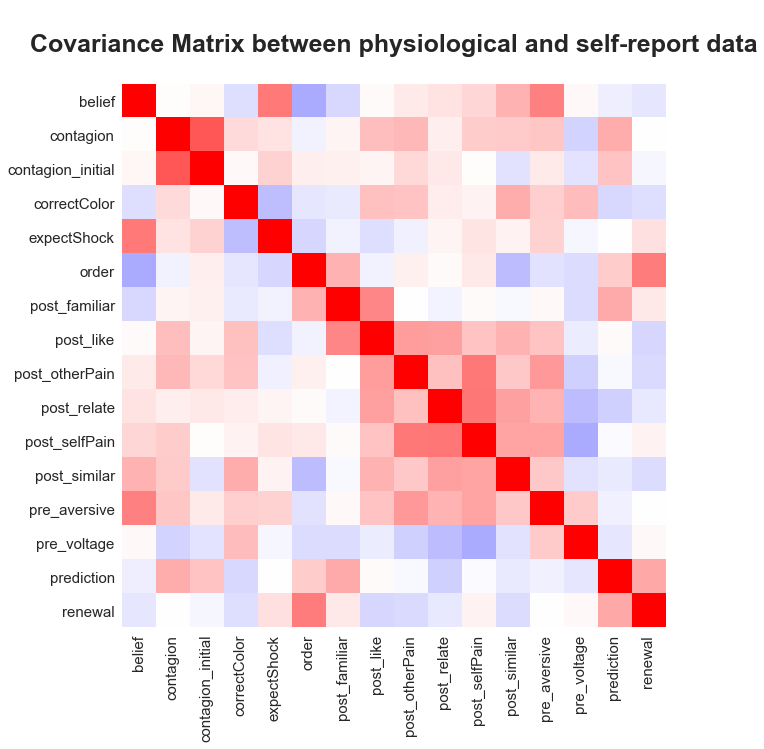

In [50]:
sns.set_style("dark", {'axes.grid' : False})
figure(figsize=[10,10])
whole_corr = physio_selfreport.corr()
imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
yticks(range(0,len(whole_corr.keys())),whole_corr.keys(), fontsize=15); 
xticks(range(0,len(whole_corr.keys())),whole_corr.keys(), rotation=90, fontsize=15); 
title('\nCovariance Matrix between physiological and self-report data\n', fontsize=25, fontweight='bold')
savefig('%scovariace_matrix_study_one.png'%results_folder)

In [51]:
def show_relationship(data_frame, x_var, y_var, color='indigo', alpha=.8, line_alpha=.1): 
    
    sns.set_style("dark", {'axes.grid' : False}, )

    X_ = data_frame[x_var].values
    y_ = data_frame[y_var].values
    
    keepers = np.array(X_ == X_) & np.array(y_ == y_)
    y = y_[keepers]
    X = X_[keepers]

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    xx = np.arange(min(X), max(X))
    yy = slope * xx + intercept
    sns.despine()
    # Print out the statistics
    
    if p_value < .05: plot(xx, yy, linewidth=20,alpha=line_alpha, color=color)
    scatter(X, y, s=600, color='white', alpha=1)
    scatter(X, y, s=150, color=color, alpha=alpha)
    
    yticks([]); xticks([])
    xlabel(x_var, fontsize=15, fontweight='bold')
    ylabel(y_var, fontsize=15, fontweight='bold')

    title('Relating %s and %s (p < %.2f)\n'%(x_var, y_var, p_value), fontsize=15, fontweight='bold')

In [52]:
def show_multiple_relationships(_11, _12, _21, _22, _31, _32, _title_, _color_, _data_, _file_title): 
    figure(figsize=[20,5])
    subplot(1,3,1)
    show_relationship(_data_, _11, _12, color=_color_)
    subplot(1,3,2)
    show_relationship(_data_, _21, _22, color=_color_)
    subplot(1,3,3)
    show_relationship(_data_, _31, _32, color=_color_)
    t = suptitle(_title_, y=1.1, fontsize=25, fontweight='bold');
    savefig('%s/%s.png'%(results_folder, _file_title), bbox_inches='tight', bbox_extra_artists=[t])

In [53]:
def show_relationship_between_expectation_and_belief(): 
    figure(figsize=[6,5])
    _belief = physio_selfreport.belief.values + (np.random.random(len(physio_selfreport.belief.values ))-.5)/5
    _expect = physio_selfreport.expectShock.values + (np.random.random(len(physio_selfreport.expectShock.values ))-.5)/5
    scatter(_belief, _expect, s=200, alpha=1, color='white')
    scatter(_belief, _expect, s=100, alpha=.5, color='xkcd:indigo')
    xlim([-.2, 1.2])
    ylim([-.2, 1.2])
    xticks([0,1], ['"No"', '"Yes"'], fontsize=15, fontweight='bold')
    yticks([0,1], ['"No"', '"Yes"'], fontsize=15, fontweight='bold')
    xlabel('\n"Did you believe that the model was being shocked \nin the video you watched yesterday?"', y=.1, fontsize=11)
    ylabel('"Did you feel like you were going to be shocked \nwhen you saw the red squares today?"\n', fontsize=11)
    t = title('Only subjects who believed model was being shocked on day one\nfelt like they were going to be shocked on day two', y=1.1, fontsize=15, fontweight='bold'); 
    savefig('%sday_one_expectation_and_belief.png'%results_folder,  bbox_inches='tight', bbox_extra_artists=[t])

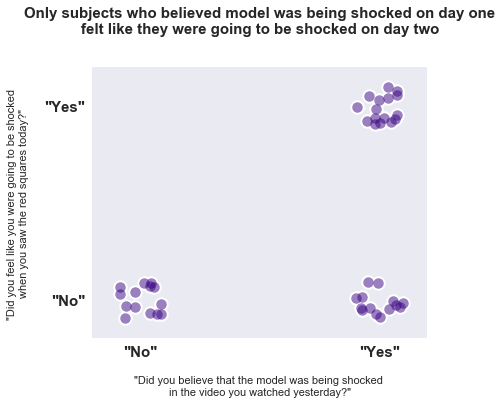

In [54]:
show_relationship_between_expectation_and_belief()

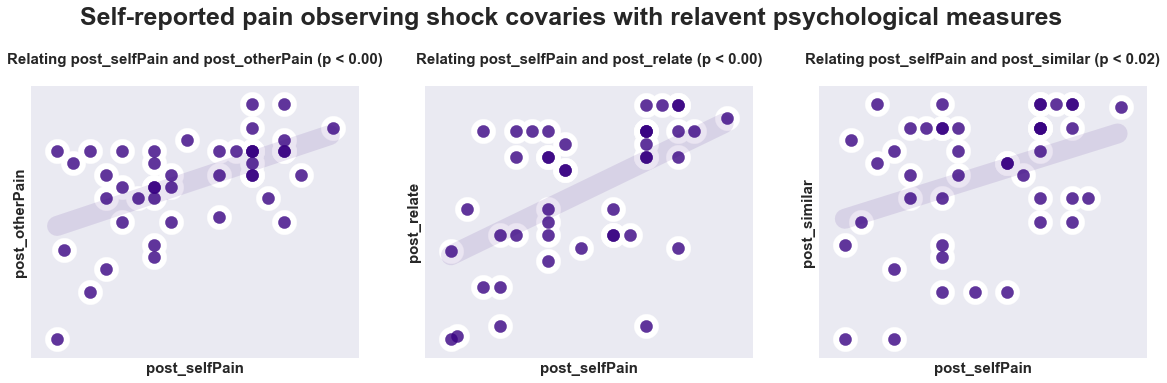

In [55]:
show_multiple_relationships('post_selfPain', 'post_otherPain', 
                            'post_selfPain', 'post_relate',
                            'post_selfPain', 'post_similar', 
                            'Self-reported pain observing shock covaries with relavent psychological measures', 
                            'xkcd:indigo', physio_selfreport, 'study_one_post_selfPain') 

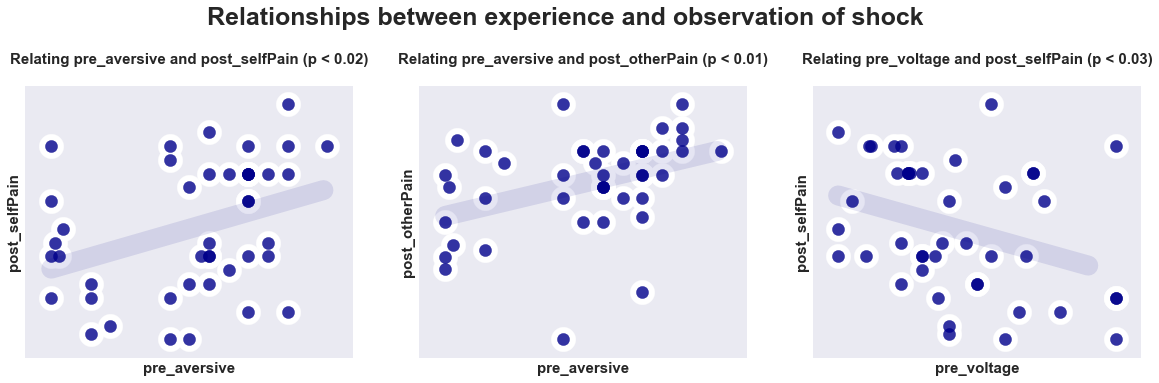

In [56]:
show_multiple_relationships('pre_aversive', 'post_selfPain', 
                            'pre_aversive', 'post_otherPain',
                            'pre_voltage' , 'post_selfPain', 
                            'Relationships between experience and observation of shock', 
                            'darkblue', physio_selfreport, 'study_one_shock_relationships') 

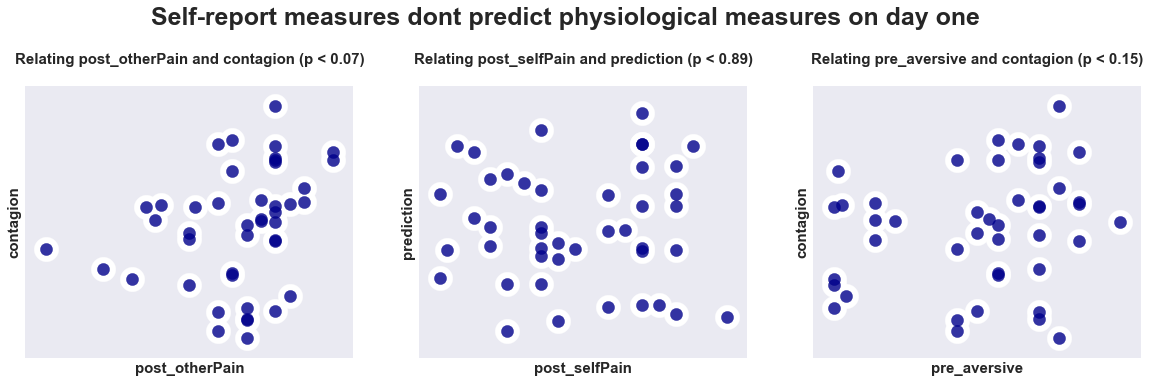

In [57]:
show_multiple_relationships('post_otherPain', 'contagion',
                            'post_selfPain', 'prediction', 
                            'pre_aversive', 'contagion',
                            'Self-report measures dont predict physiological measures on day one', 
                            'darkblue', physio_selfreport, 'study_one_self_report_non_physio') 

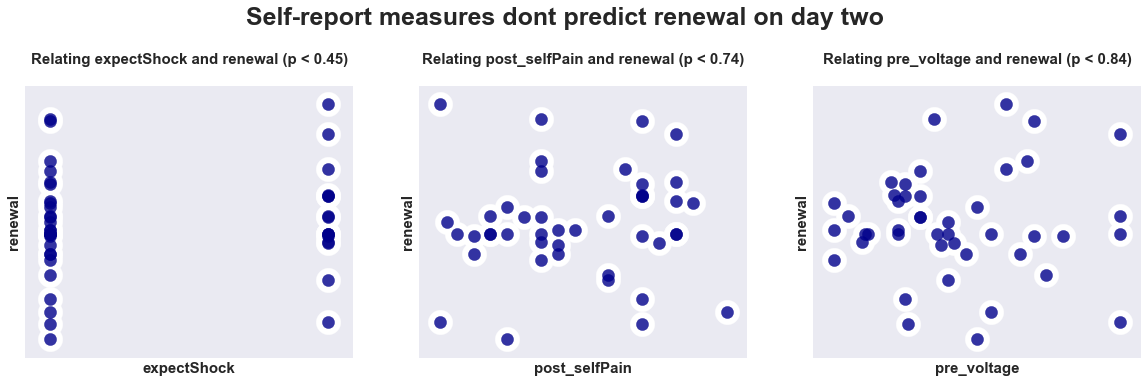

In [58]:
show_multiple_relationships('expectShock','renewal', 
                            'post_selfPain', 'renewal', 
                            'pre_voltage', 'renewal',
                            'Self-report measures dont predict renewal on day two', 
                            'darkblue', physio_selfreport, 'day_one_self_report_non_renewal') 

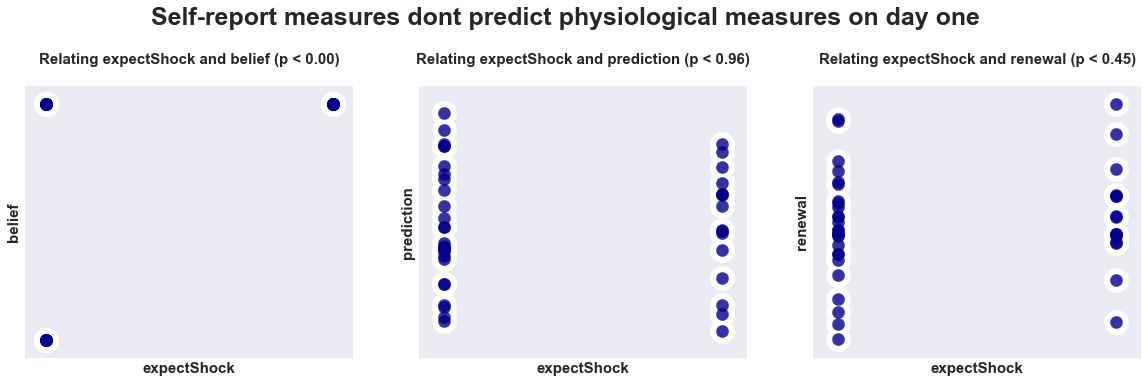

In [59]:
show_multiple_relationships('expectShock', 'belief',
                            'expectShock', 'prediction', 
                            'expectShock', 'renewal',
                            'Self-report measures dont predict physiological measures on day one', 
                            'darkblue', physio_selfreport, 'study_one_self_report_non_physio') 

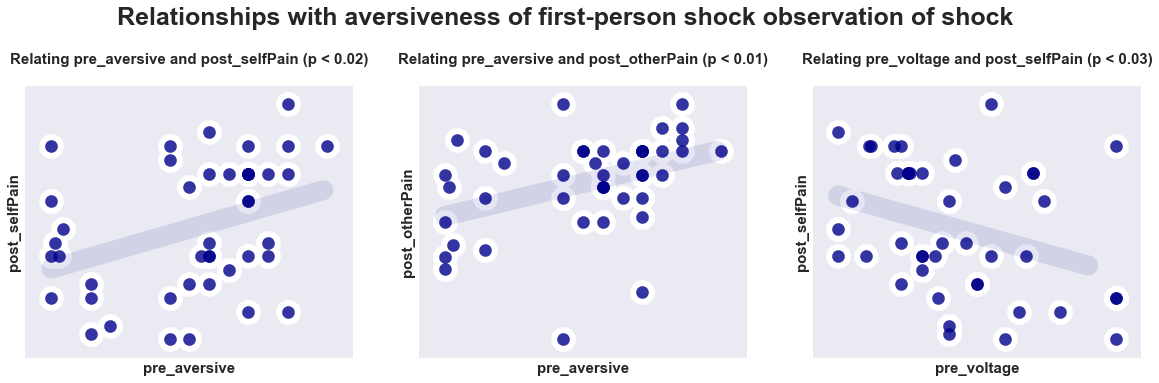

In [60]:
show_multiple_relationships('pre_aversive', 'post_selfPain', 
                            'pre_aversive', 'post_otherPain',
                            'pre_voltage' , 'post_selfPain', 
                            'Relationships with aversiveness of first-person shock observation of shock', 
                            'darkblue', physio_selfreport, 'first_person_shock') 

In [61]:
# physio_selfreport.keys()

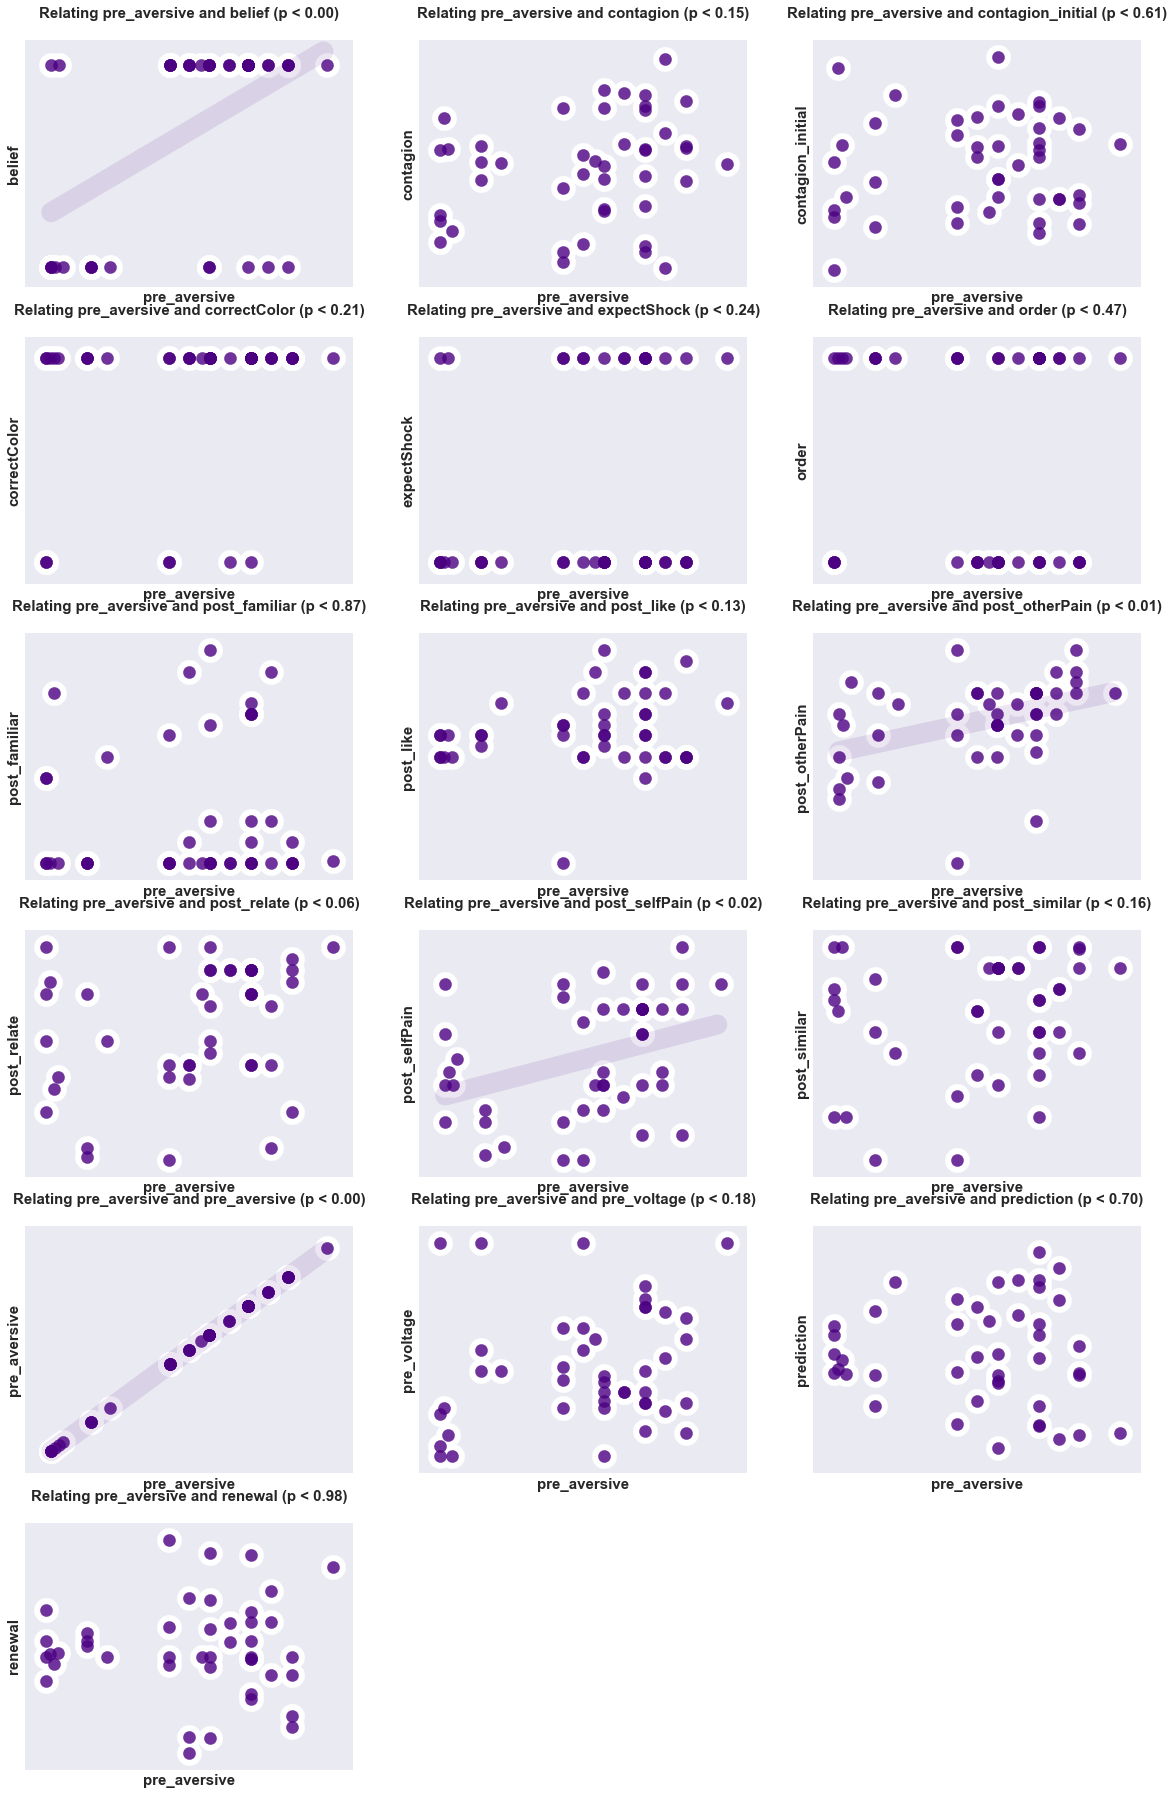

In [62]:
figure(figsize=[20,60+10])
avoid = ['first', 'color', 'post_color', 'subject_names', 'third']
count = 1
for ii in physio_selfreport.keys():
    if ii not in avoid: 
        subplot(13,3,count) ; count = count + 1 
        show_relationship(physio_selfreport, 'pre_aversive', ii)